In [1]:
import torch

# Check if CUDA is available
cuda_available = torch.cuda.is_available()
cuda_version = torch.version.cuda if cuda_available else "CUDA not available"
cudnn_version = torch.backends.cudnn.version() if cuda_available else "cuDNN not available"

print(f"CUDA Available: {cuda_available}")
print(f"CUDA Version: {cuda_version}")
print(f"cuDNN Version: {cudnn_version}")

# Check the GPU device name
if cuda_available:
    gpu_name = torch.cuda.get_device_name(0)
    print(f"GPU Name: {gpu_name}")

CUDA Available: False
CUDA Version: CUDA not available
cuDNN Version: cuDNN not available


# S&P 500 Prediction Analysis using Toto

This notebook walks through the process of fetching S&P 500 data, preparing it for the Toto model, and generating predictions. We'll examine the data and results at each important step.

In [2]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prepare_stock_data import fetch_sp500_data, prepare_for_toto
from toto.model.toto import Toto
from toto.inference.forecaster import TotoForecaster

# Set plotting style
# plt.style.use('seaborn')
# sns.set_palette("husl")

/opt/anaconda3/envs/toto/lib/python3.10/site-packages/gluonts/json.py:102: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


## 1. Data Collection

First, let's fetch the S&P 500 data and examine its basic properties.

In [3]:
# Fetch data
data = fetch_sp500_data()

print("Data shape:", data.shape)
print("\nDate range:")
print(f"Start: {data.index[0]}")
print(f"End: {data.index[-1]}")

# Display first few rows
display(data.head())

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

Data shape: (3334, 9)

Date range:
Start: 2023-06-30 13:30:00+00:00
End: 2025-05-29 13:30:00+00:00


,Open,High,Low,Close,Volume,Volume_MA,Price_MA_short,Price_MA_long,Volatility
Datetime,,,,,,,,,
2023-06-30 13:30:00+00:00,4422.439941,4449.129883,4422.439941,4445.970215,456406930,NaN,NaN,NaN,NaN
2023-06-30 14:30:00+00:00,4445.979980,4448.700195,4436.250000,4442.640137,284352271,NaN,NaN,NaN,NaN
2023-06-30 15:30:00+00:00,4442.560059,4446.100098,4435.930176,4446.100098,211529403,NaN,NaN,NaN,NaN
2023-06-30 16:30:00+00:00,4446.200195,4451.470215,4445.740234,4450.950195,170891396,NaN,NaN,NaN,NaN
2023-06-30 17:30:00+00:00,4450.979980,4456.720215,4450.689941,4456.310059,185112000,NaN,NaN,NaN,NaN


## 2. Data Visualization

Let's visualize the key features of our dataset.

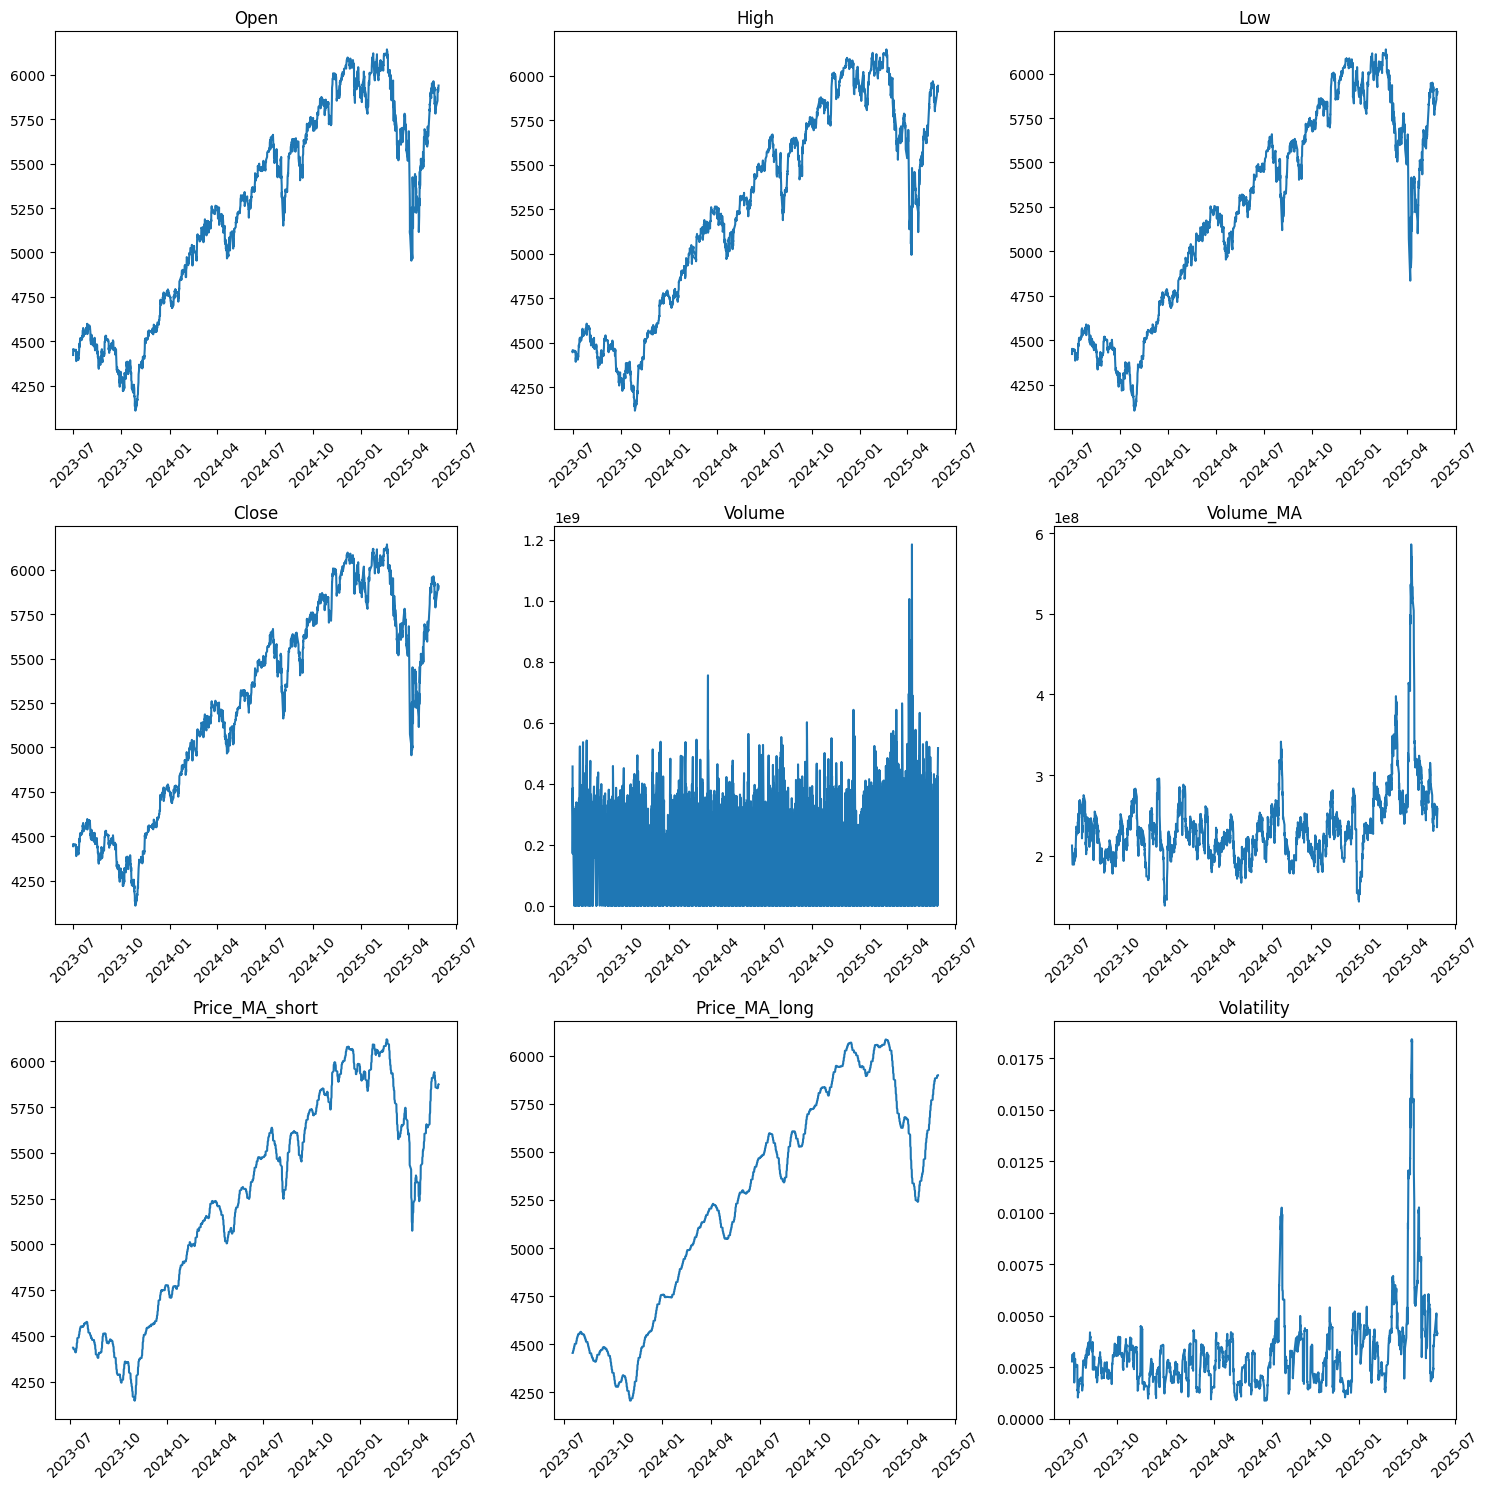

In [4]:
def plot_features(data, columns, rows=3):
    cols = (len(columns) + rows - 1) // rows
    fig, axes = plt.subplots(rows, cols, figsize=(15, 5*rows))
    axes = axes.flatten()
    
    for i, col in enumerate(columns):
        axes[i].plot(data.index, data[col])
        axes[i].set_title(col)
        axes[i].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    display(plt.gcf())
    plt.close()

# Plot all features
plot_features(data, data.columns)

## 3. Data Normalization

Let's examine how our robust normalization affects the data distribution.

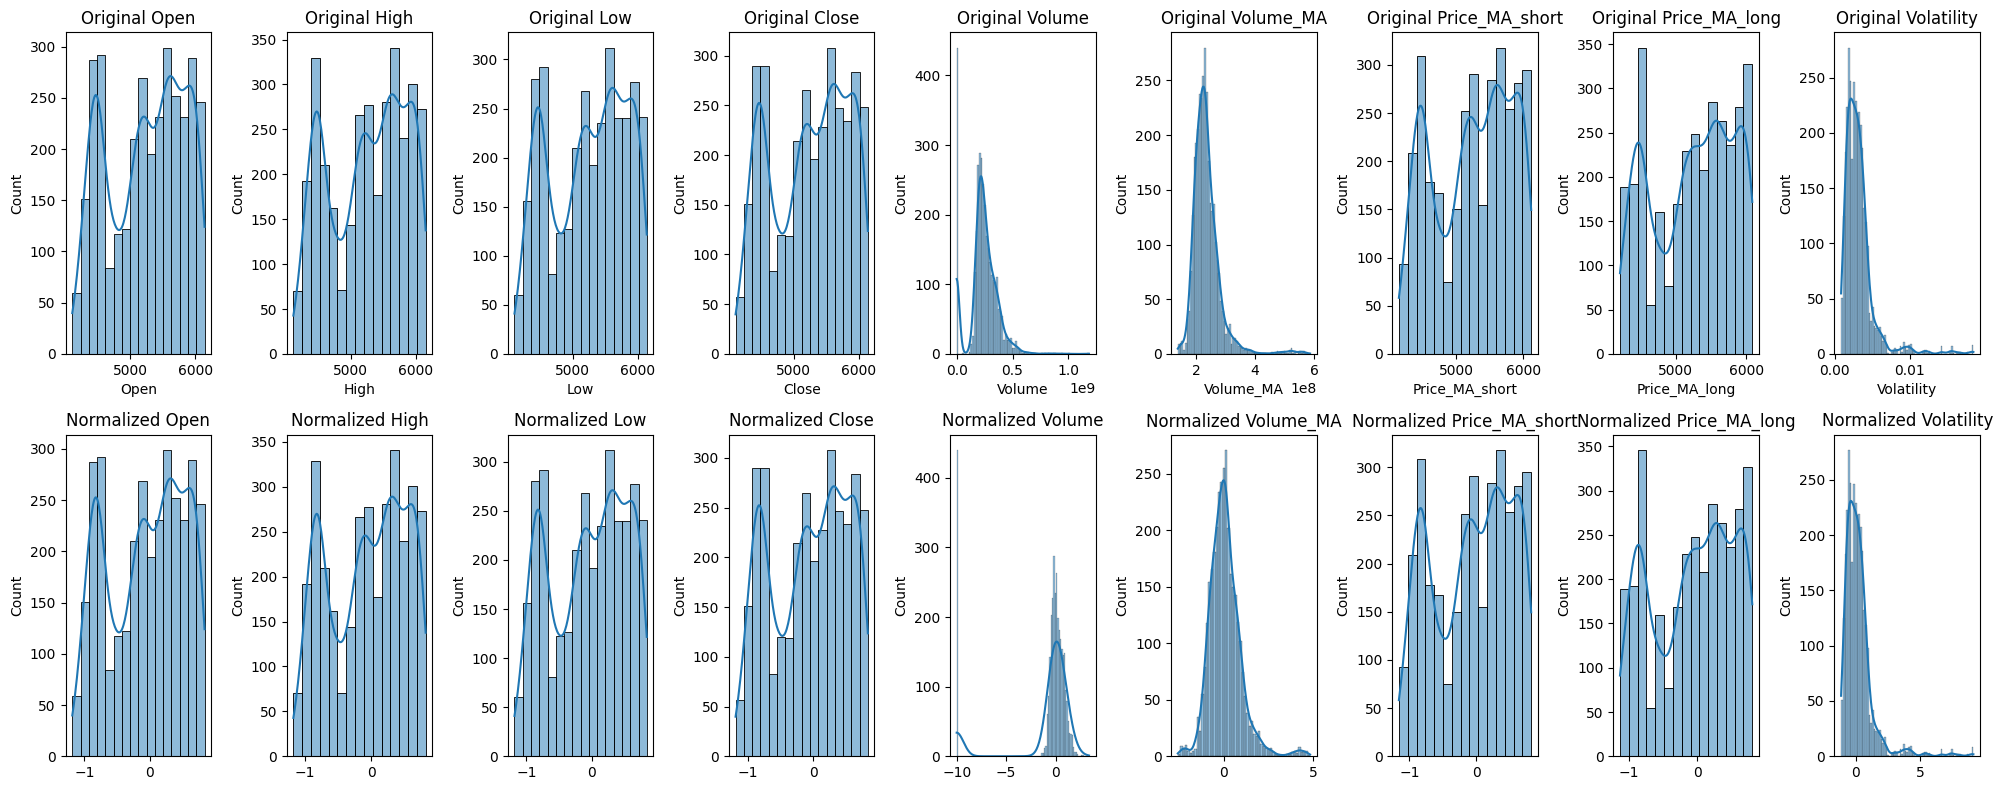

In [5]:
def plot_distributions(data, normalized_data):
    fig, axes = plt.subplots(2, len(data.columns), figsize=(20, 8))
    
    for i, col in enumerate(data.columns):
        # Original distribution
        sns.histplot(data[col], ax=axes[0, i], kde=True)
        axes[0, i].set_title(f'Original {col}')
        
        # Normalized distribution
        sns.histplot(normalized_data[col], ax=axes[1, i], kde=True)
        axes[1, i].set_title(f'Normalized {col}')
    
    plt.tight_layout()
    display(plt.gcf())
    plt.close()

# Get normalized data (before tensor conversion)
normalized_data = {}
for column in data.columns:
    series = data[column].values
    
    if column in ['Volume', 'Volume_MA']:
        series = np.log1p(series)
    elif column == 'Volatility':
        series = np.maximum(series, 0)
    
    q1 = np.percentile(series[~np.isnan(series)], 25)
    q3 = np.percentile(series[~np.isnan(series)], 75)
    iqr = q3 - q1
    
    if iqr > 0:
        median = np.median(series[~np.isnan(series)])
        normalized_data[column] = (series - median) / (iqr + 1e-8)
    else:
        mean = np.mean(series[~np.isnan(series)])
        std = np.std(series[~np.isnan(series)])
        normalized_data[column] = (series - mean) / (std + 1e-8)
    
    normalized_data[column] = np.clip(normalized_data[column], -10, 10)

# Plot distributions
plot_distributions(data, normalized_data)

Using device: cpu

Backtesting Information:
Training data ends at: 2025-05-23 14:30:00+00:00
Test data starts at: 2025-05-23 15:30:00+00:00
Test data ends at: 2025-05-29 13:30:00+00:00

Error Metrics for Close Price:
Mean Absolute Percentage Error (MAPE): 1.40%
Root Mean Square Error (RMSE): 93.14
Mean Absolute Error (MAE): 82.95


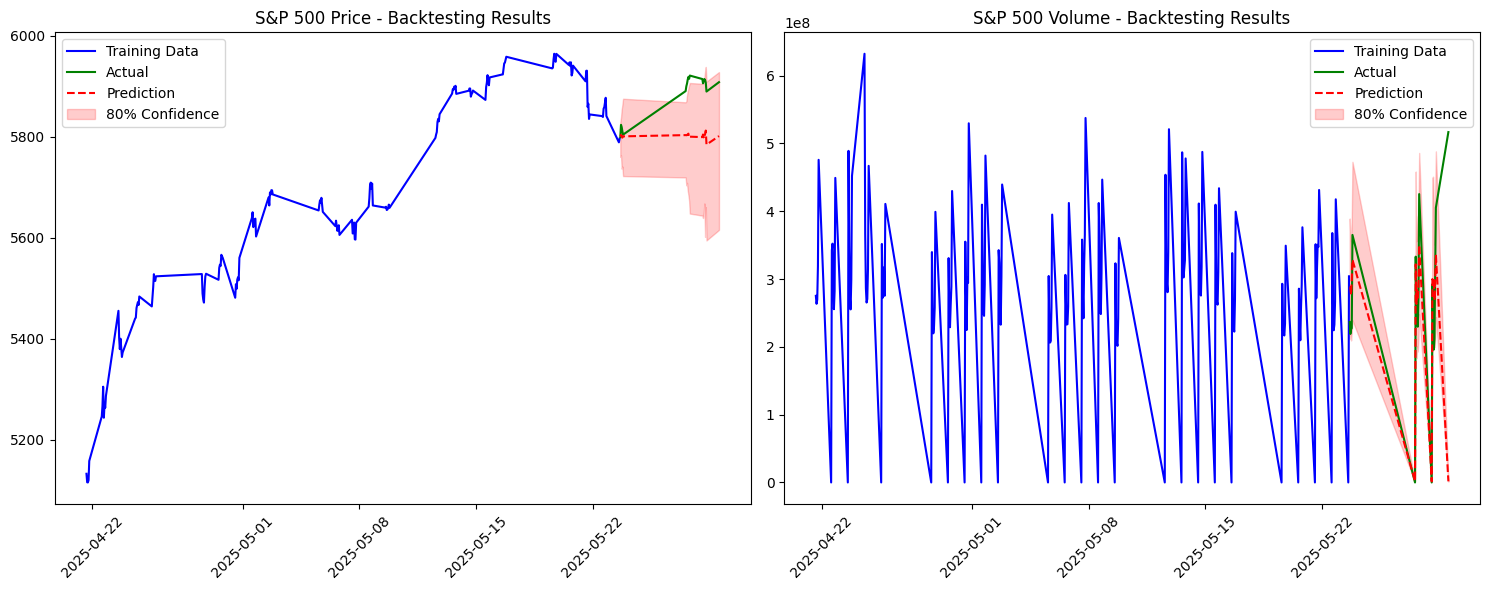

In [6]:
# Single cell backtesting code
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from prepare_stock_data import prepare_for_toto, denormalize_predictions




device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

toto = Toto.from_pretrained('Datadog/Toto-Open-Base-1.0').to(device)
toto.compile()

# Create forecaster
forecaster = TotoForecaster(toto.model)



# Prepare training data (excluding test period)
train_data = data.iloc[:-20].copy()
test_data = data.iloc[-20:].copy()

print("\nBacktesting Information:")
print(f"Training data ends at: {train_data.index[-1]}")
print(f"Test data starts at: {test_data.index[0]}")
print(f"Test data ends at: {test_data.index[-1]}")

# Prepare data for Toto
toto_input, normalization_params = prepare_for_toto(train_data, device=device)

# Generate forecasts for test period
prediction_hours = len(test_data)  # Length of test data
forecast = forecaster.forecast(
    toto_input,
    prediction_length=prediction_hours,
    num_samples=256,
    samples_per_batch=256,
)

# Get predictions
median_pred = forecast.median
lower_pred = forecast.quantile(0.1)  # 10th percentile
upper_pred = forecast.quantile(0.9)  # 90th percentile

# Denormalize predictions
denorm_median = denormalize_predictions(median_pred, normalization_params, data.columns)
denorm_lower = denormalize_predictions(lower_pred, normalization_params, data.columns)
denorm_upper = denormalize_predictions(upper_pred, normalization_params, data.columns)

# Calculate error metrics for Close price
close_idx = data.columns.get_loc('Close')
predicted_close = denorm_median[0, close_idx, :]
actual_close = test_data['Close'].values

mape = np.mean(np.abs((actual_close - predicted_close) / actual_close)) * 100
rmse = np.sqrt(np.mean((actual_close - predicted_close) ** 2))
mae = np.mean(np.abs(actual_close - predicted_close))

print("\nError Metrics for Close Price:")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Root Mean Square Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")

# Plot backtesting results
plt.figure(figsize=(15, 6))

# Plot Close price backtesting
plt.subplot(1, 2, 1)
plt.title('S&P 500 Price - Backtesting Results')
plt.plot(train_data.index[-168:], train_data['Close'][-168:], label='Training Data', color='blue')
plt.plot(test_data.index, test_data['Close'], label='Actual', color='green')
plt.plot(test_data.index, denorm_median[0, close_idx, :], 
         label='Prediction', color='red', linestyle='--')
plt.fill_between(test_data.index, 
                 denorm_lower[0, close_idx, :],
                 denorm_upper[0, close_idx, :],
                 color='red', alpha=0.2, label='80% Confidence')
plt.legend()
plt.xticks(rotation=45)

# Plot Volume backtesting
volume_idx = data.columns.get_loc('Volume')
plt.subplot(1, 2, 2)
plt.title('S&P 500 Volume - Backtesting Results')
plt.plot(train_data.index[-168:], train_data['Volume'][-168:], label='Training Data', color='blue')
plt.plot(test_data.index, test_data['Volume'], label='Actual', color='green')
plt.plot(test_data.index, denorm_median[0, volume_idx, :], 
         label='Prediction', color='red', linestyle='--')
plt.fill_between(test_data.index, 
                 denorm_lower[0, volume_idx, :],
                 denorm_upper[0, volume_idx, :],
                 color='red', alpha=0.2, label='80% Confidence')
plt.legend()
plt.xticks(rotation=45)

plt.tight_layout()
display(plt.gcf())
plt.close()

## 5. Visualization of Predictions

Let's visualize the predictions with confidence intervals for each feature.

/var/folders/m4/3w24mz_90fz_9mtbj3kdr0_r0000gp/T/ipykernel_44555/1977045085.py:6: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  future_timestamps = pd.date_range(


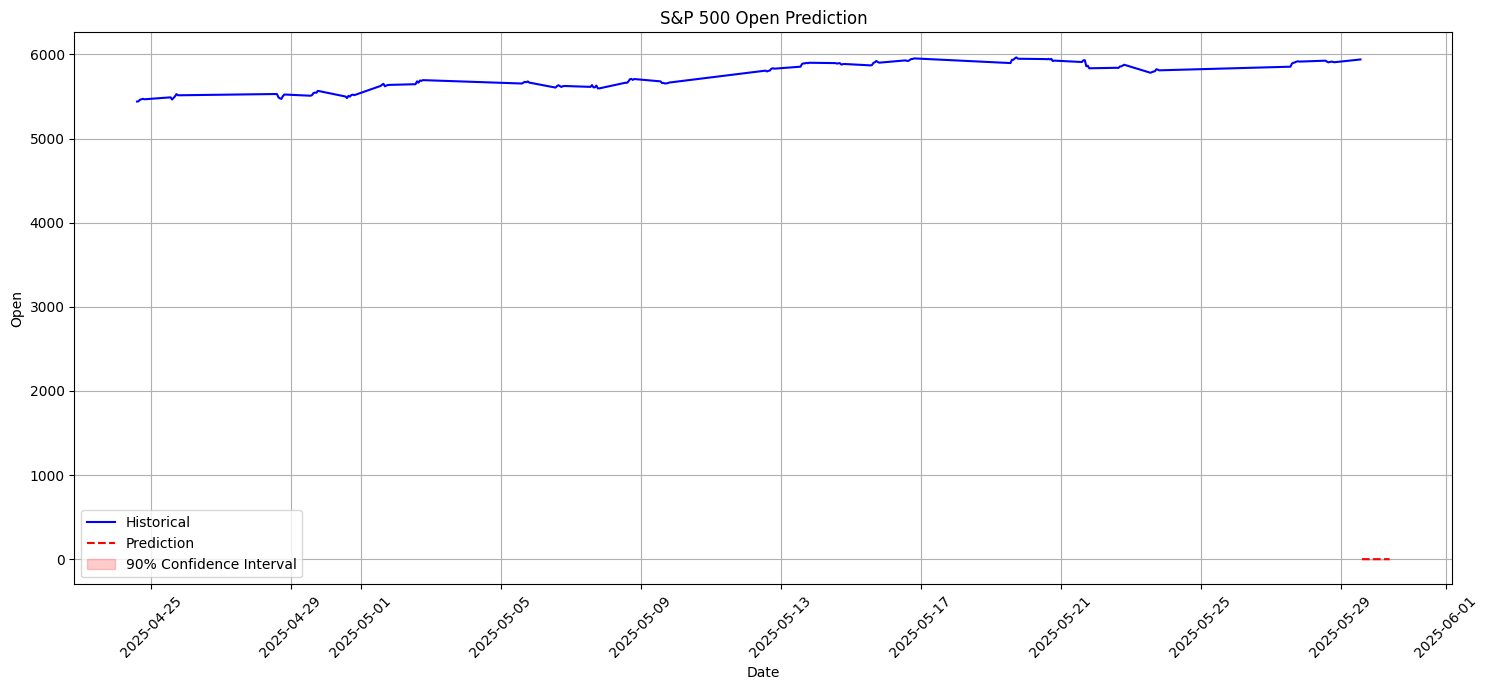

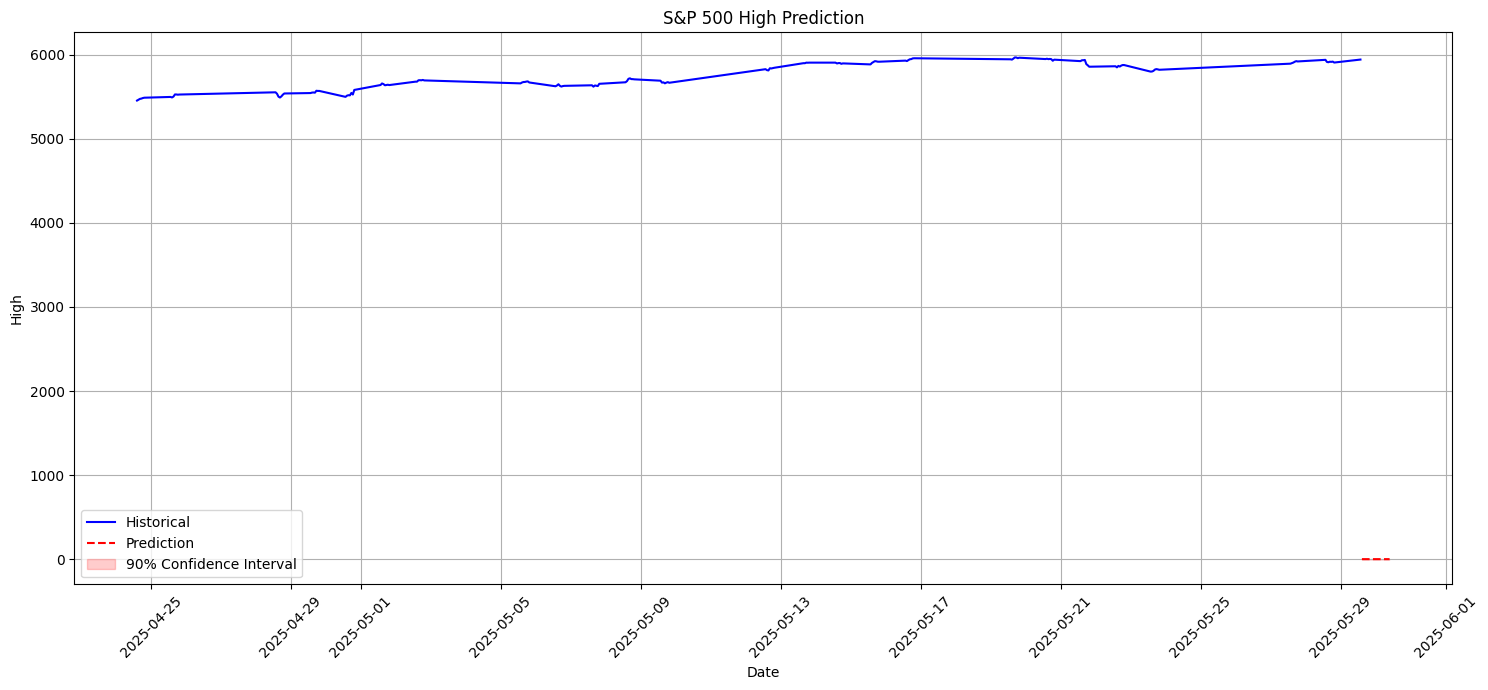

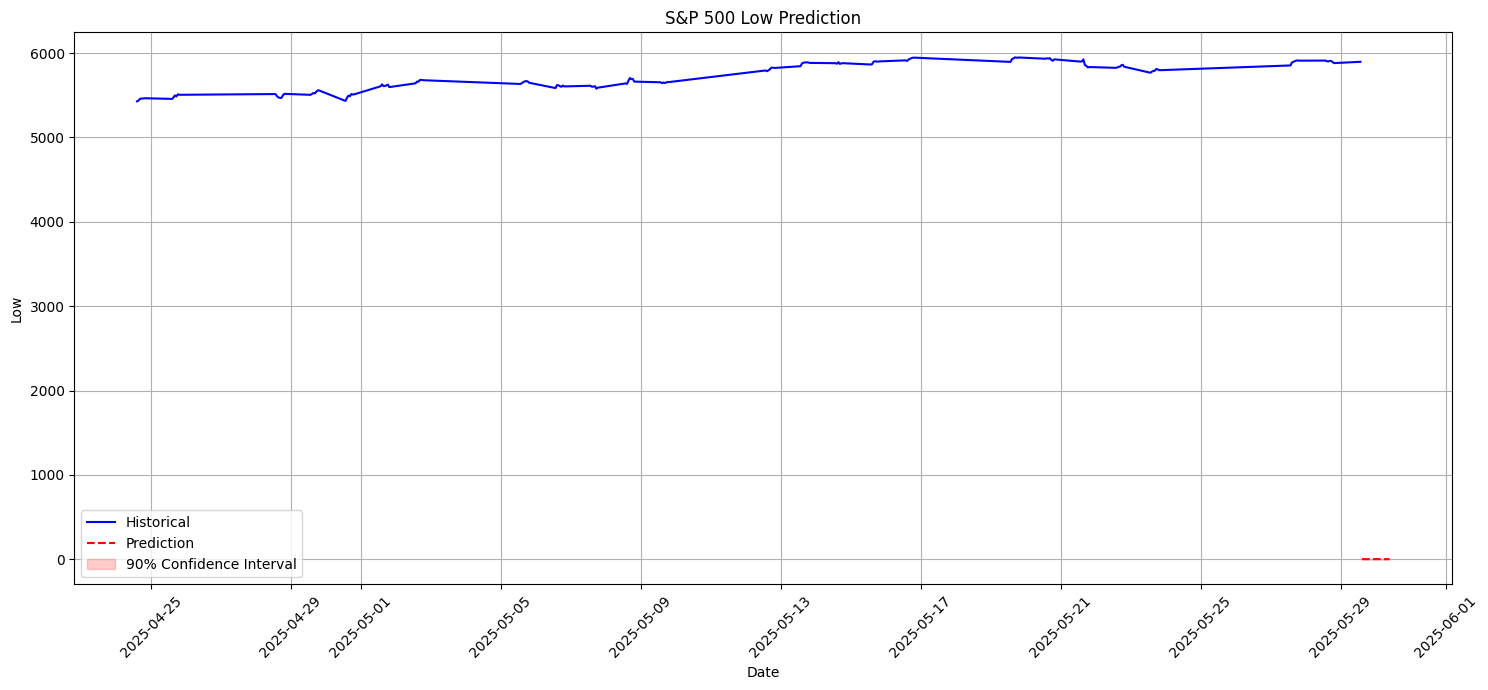

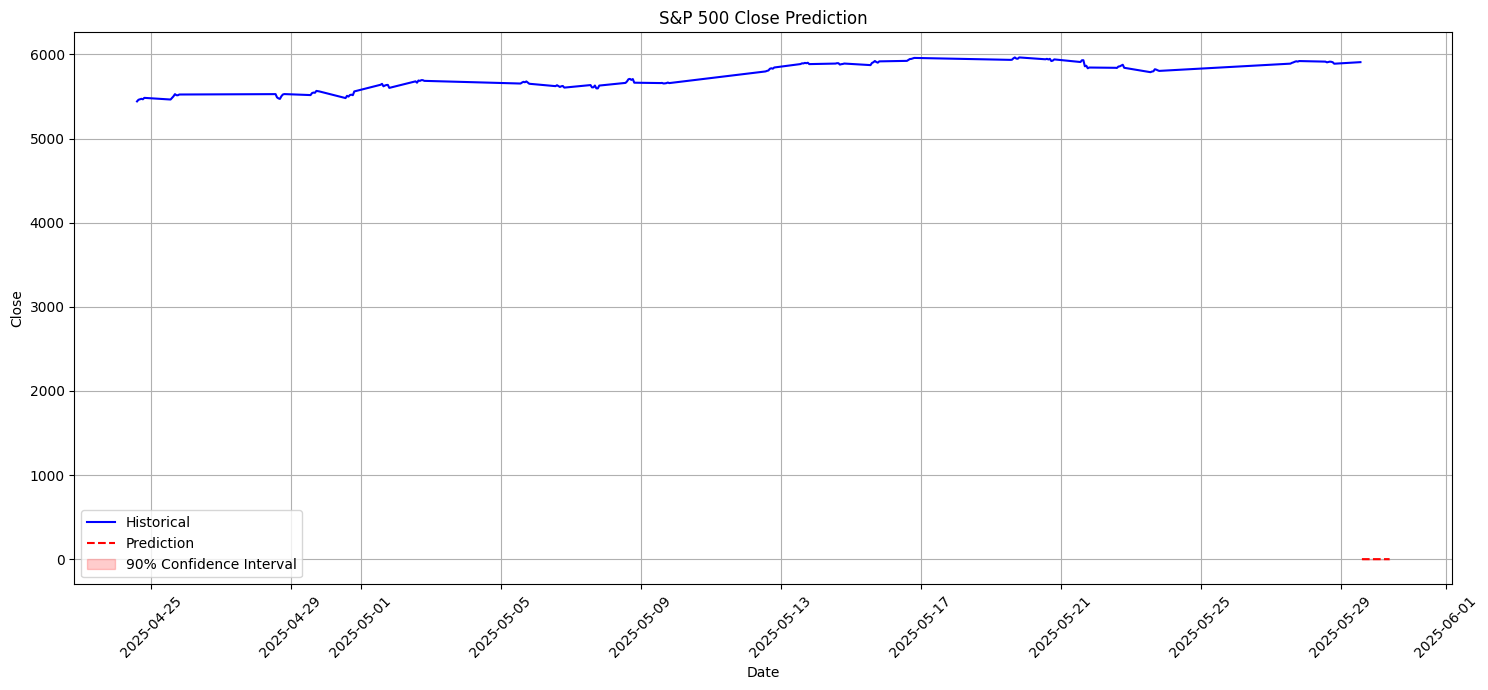

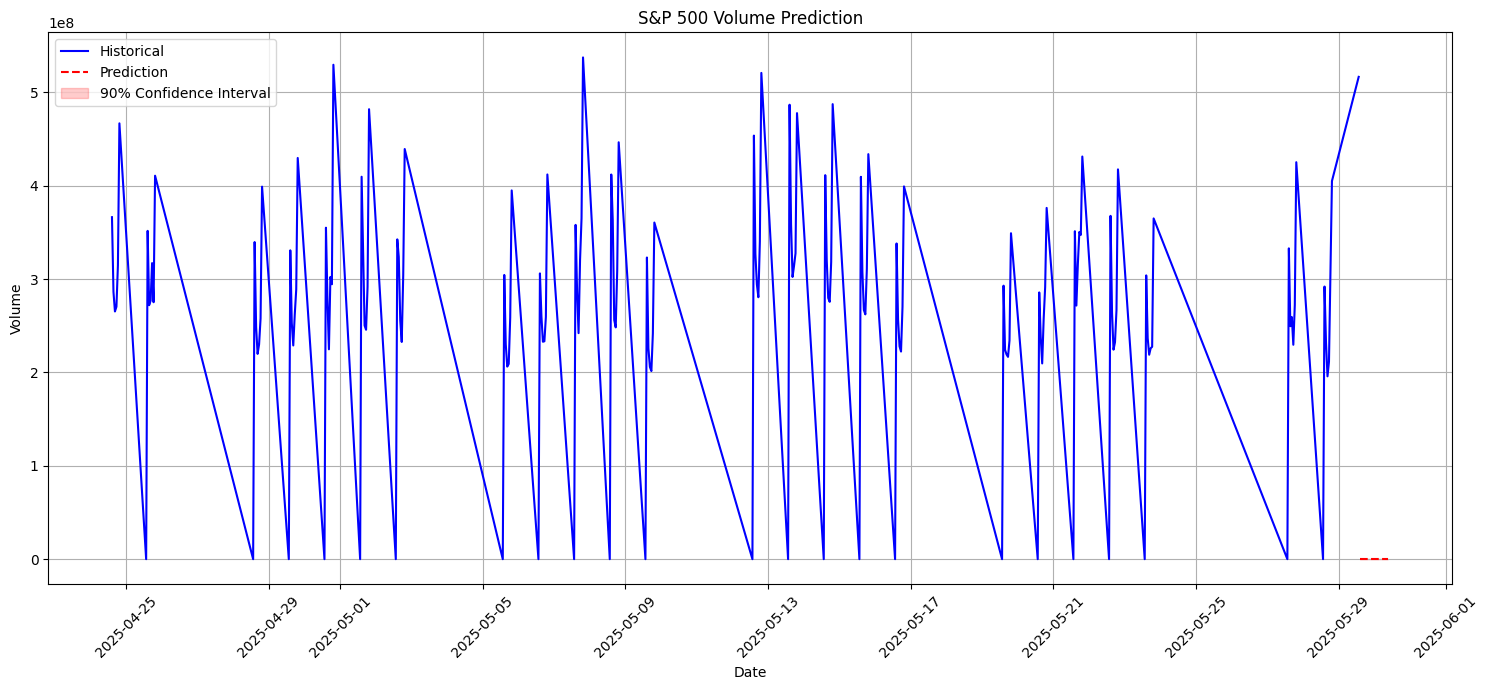

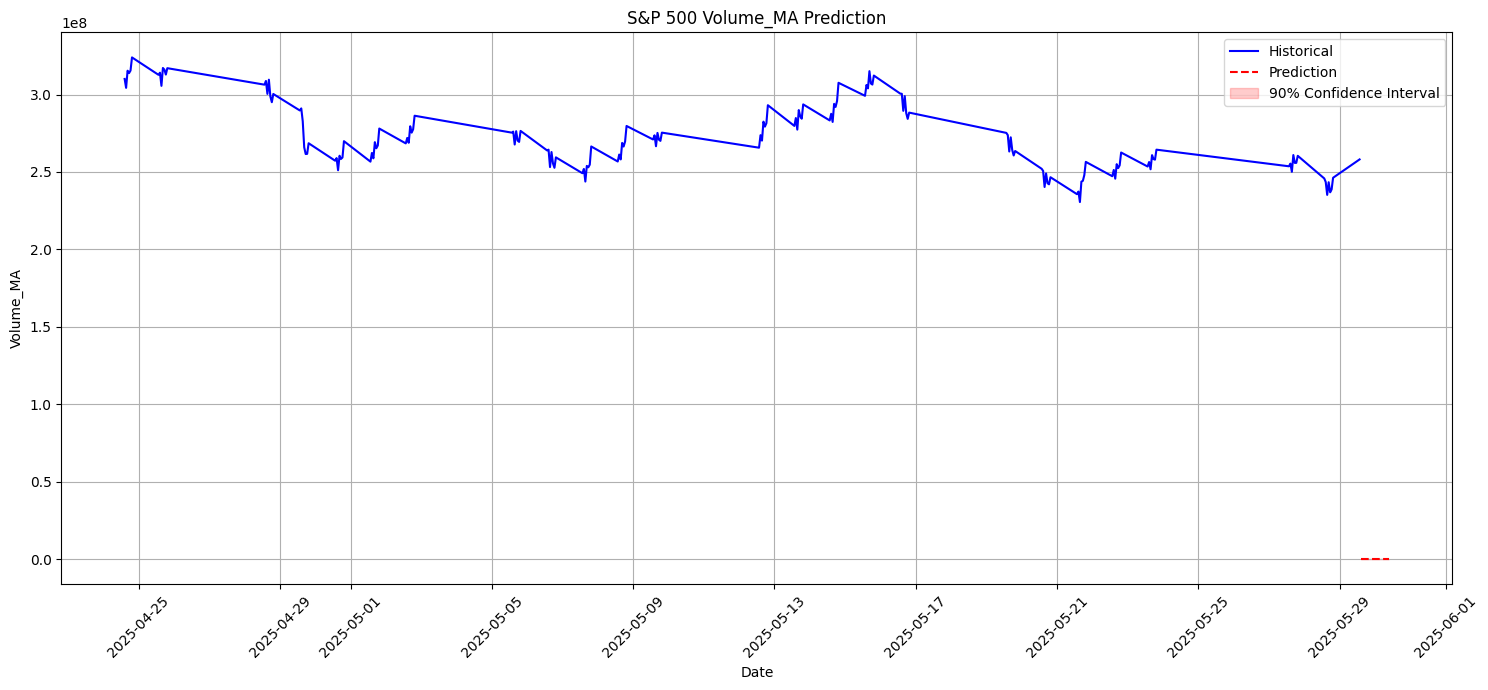

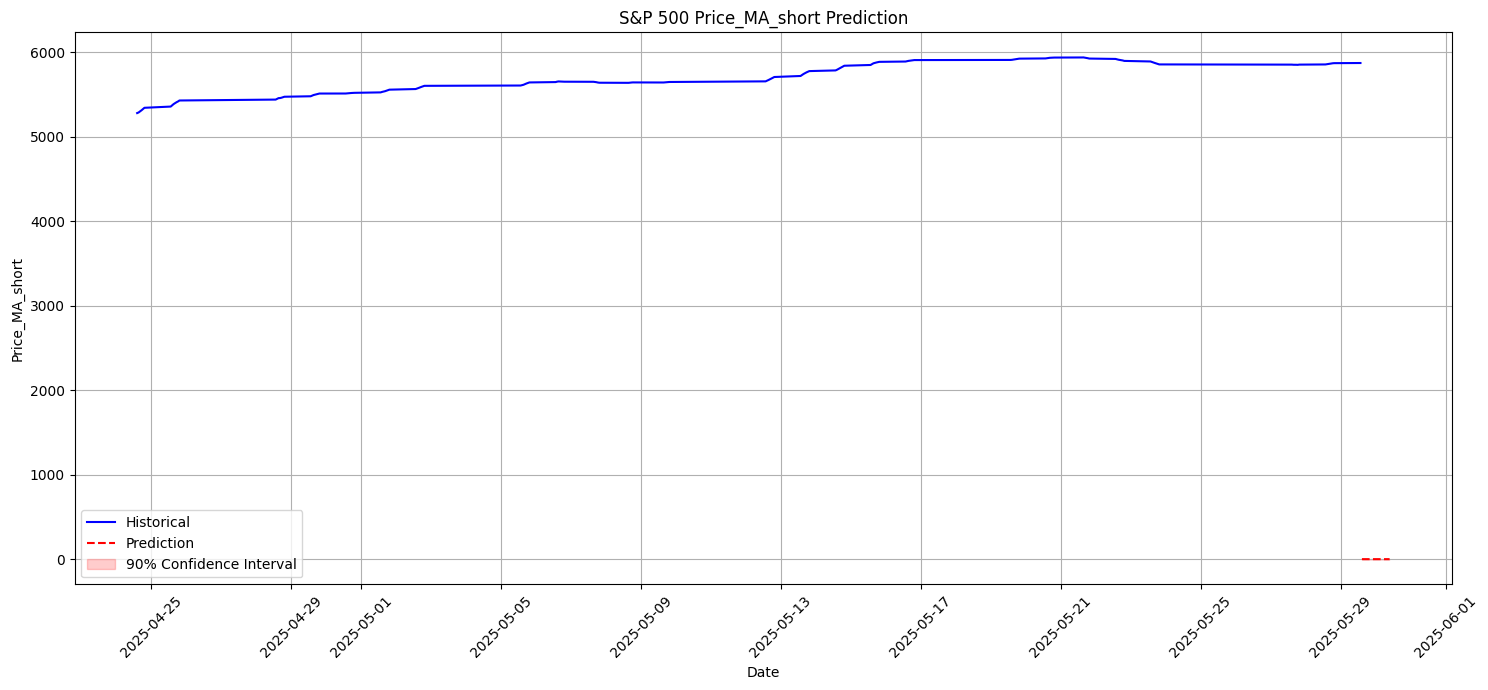

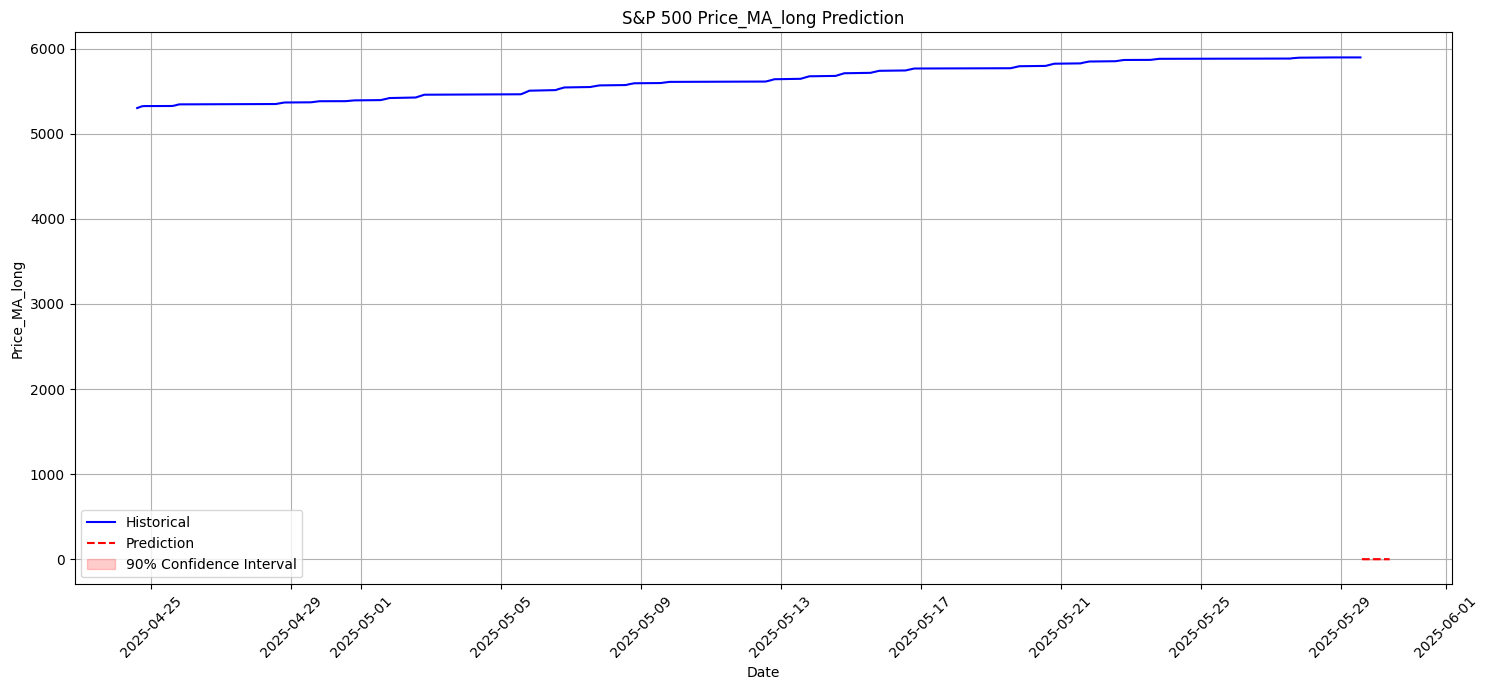

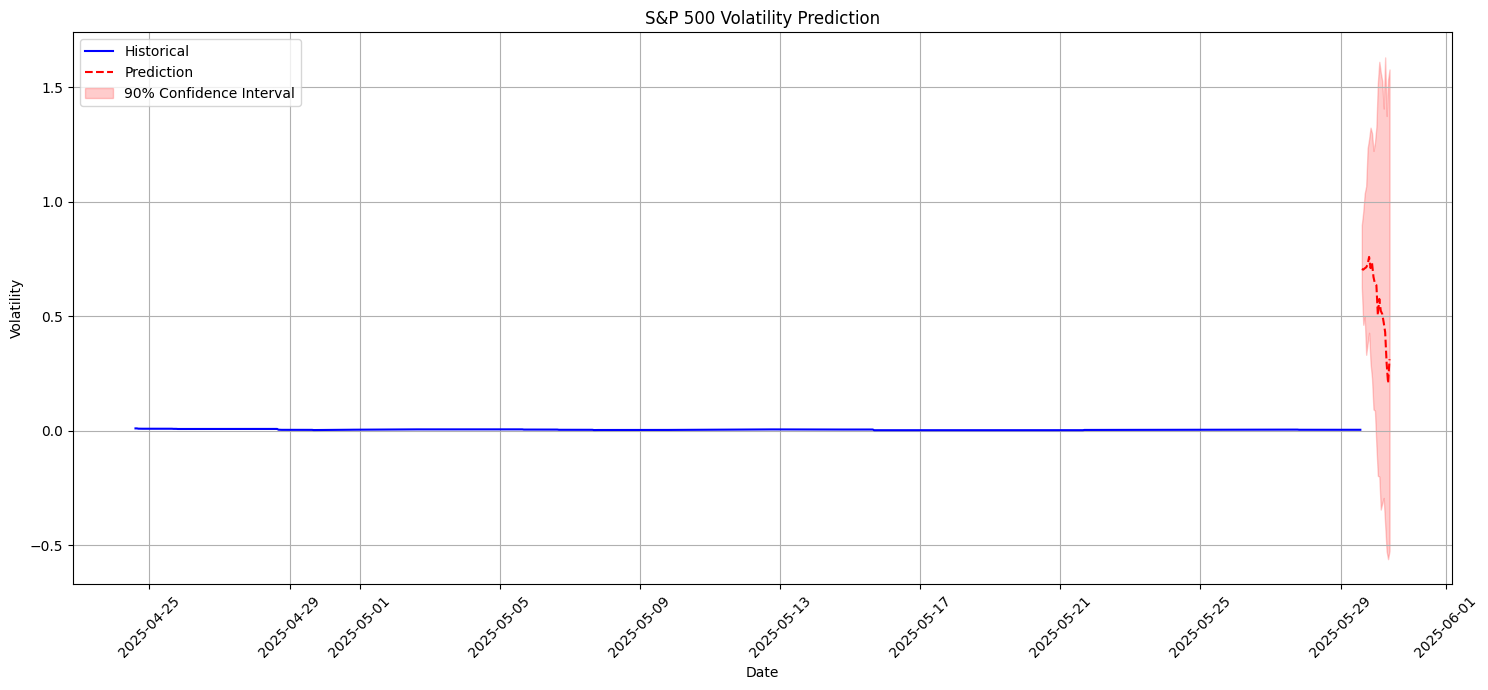

In [8]:
def plot_predictions(data, forecast, feature_idx, feature_name):
    # Get the last timestamp from historical data
    last_timestamp = data.index[-1]
    
    # Create future timestamps
    future_timestamps = pd.date_range(
        start=last_timestamp,
        periods=forecast.median.shape[-1] + 1,
        freq='H'
    )[1:]
    
    plt.figure(figsize=(15, 7))
    
    # Plot historical data
    plt.plot(data.index[-168:], data[feature_name].values[-168:], 
             label='Historical', color='blue')
    
    # Plot predictions
    median_pred = forecast.median[0, feature_idx].cpu().numpy()
    lower_pred = forecast.quantile(0.1)[0, feature_idx].cpu().numpy()
    upper_pred = forecast.quantile(0.9)[0, feature_idx].cpu().numpy()
    
    plt.plot(future_timestamps, median_pred, 
             label='Prediction', color='red', linestyle='--')
    plt.fill_between(future_timestamps, lower_pred, upper_pred, 
                     color='red', alpha=0.2, label='90% Confidence Interval')
    
    plt.title(f'S&P 500 {feature_name} Prediction')
    plt.xlabel('Date')
    plt.ylabel(feature_name)
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    display(plt.gcf())
    plt.close()

# Plot predictions for each feature
for idx, feature in enumerate(data.columns):
    plot_predictions(data, forecast, idx, feature)

## 6. Analysis of Prediction Quality

Let's analyze the quality of our predictions by looking at the distribution of samples and uncertainty.

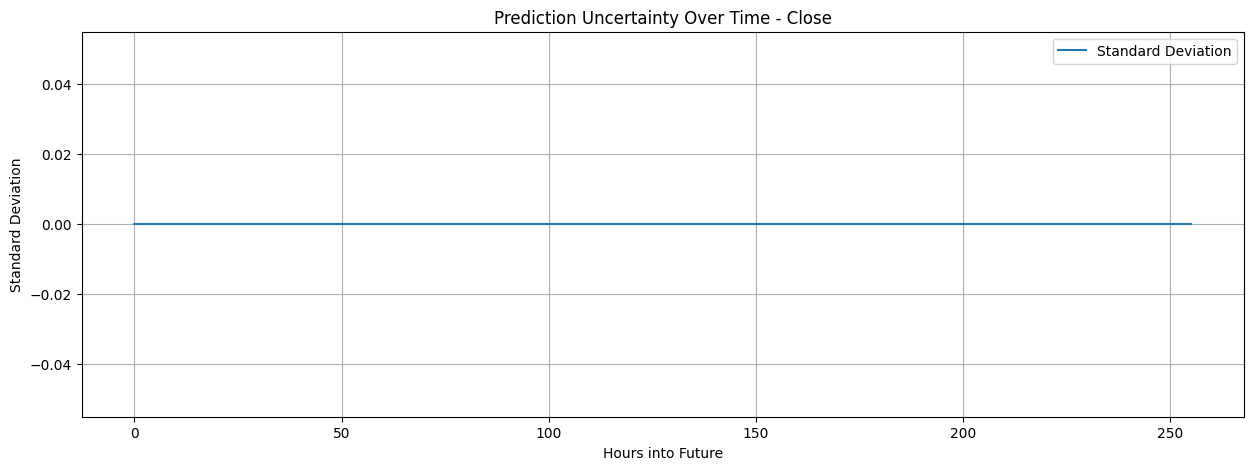

In [9]:
def analyze_prediction_uncertainty(forecast, feature_idx, feature_name):
    # Get all samples for the feature
    samples = forecast.samples[:, 0, feature_idx].cpu().numpy()
    
    # Calculate uncertainty metrics
    std_dev = np.std(samples, axis=0)
    mean = np.mean(samples, axis=0)
    
    plt.figure(figsize=(15, 5))
    
    # Plot standard deviation over time
    plt.plot(std_dev, label='Standard Deviation')
    plt.title(f'Prediction Uncertainty Over Time - {feature_name}')
    plt.xlabel('Hours into Future')
    plt.ylabel('Standard Deviation')
    plt.legend()
    plt.grid(True)
    display(plt.gcf())
    plt.close()

# Analyze uncertainty for Close price
analyze_prediction_uncertainty(forecast, 3, 'Close')

## 7. Save Results to Delta Table (Databricks-specific)

Let's save our predictions to a Delta table for future reference.

In [ ]:
# # Create a DataFrame with predictions
# def create_predictions_df(data, forecast, feature_name, feature_idx):
#     last_timestamp = data.index[-1]
#     future_timestamps = pd.date_range(
#         start=last_timestamp,
#         periods=forecast.median.shape[-1] + 1,
#         freq='H'
#     )[1:]
    
#     predictions_df = pd.DataFrame({
#         'timestamp': future_timestamps,
#         'feature': feature_name,
#         'median_prediction': forecast.median[0, feature_idx].cpu().numpy(),
#         'lower_bound': forecast.quantile(0.1)[0, feature_idx].cpu().numpy(),
#         'upper_bound': forecast.quantile(0.9)[0, feature_idx].cpu().numpy()
#     })
    
#     return predictions_df

# # Combine predictions for all features
# all_predictions = []
# for idx, feature in enumerate(data.columns):
#     feature_predictions = create_predictions_df(data, forecast, feature, idx)
#     all_predictions.append(feature_predictions)

# predictions_df = pd.concat(all_predictions, ignore_index=True)

# # Convert to Spark DataFrame and save as Delta table
# # spark_predictions = spark.createDataFrame(predictions_df)
# # spark_predictions.write.format("delta").mode("overwrite").saveAsTable("sp500_predictions")

## 8. Query Saved Predictions (Databricks-specific)

In [13]:
# %sql
# -- Example query to view predictions
# SELECT *
# FROM sp500_predictions
# WHERE feature = 'Close'
# ORDER BY timestamp; 

### Backtesting